In [1]:
import ctypes

In [2]:
basic_dll = ctypes.CDLL('fourier_basic.so')

In [3]:
basic_dll.density_fourier_capi_float.restype = ctypes.c_int
basic_dll.density_fourier_capi_float.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_long, ctypes.c_float, ctypes.c_float]
basic_dll.density_fourier_capi_double.restype = ctypes.c_int
basic_dll.density_fourier_capi_double.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_long, ctypes.c_double, ctypes.c_double]

In [4]:
import numpy as np

In [5]:
def density_fourier_float(data: np.array, hcount = 32):
    fp_data = np.ascontiguousarray(data, dtype = np.float32)
    scount = len(fp_data)
    re_harm, im_harm = np.zeros(hcount, dtype = np.float32), np.zeros(hcount, dtype = np.float32) 
    dmin, dmax = np.min(data), np.max(data)
    shift, basek = 0.5 * (dmax + dmin), 2 * np.pi / np.abs(dmax - dmin)
    res = basic_dll.density_fourier_capi_float(  \
        fp_data.ctypes.data_as(ctypes.c_void_p), \
        re_harm.ctypes.data_as(ctypes.c_void_p), \
        im_harm.ctypes.data_as(ctypes.c_void_p), \
        scount, hcount, shift, basek)
    assert res == 0
    return (re_harm, im_harm)

def density_fourier_double(data: np.array, hcount = 32):
    fp_data = np.ascontiguousarray(data, dtype = np.float64)
    scount = len(fp_data)
    re_harm, im_harm = np.zeros(hcount, dtype = np.float64), np.zeros(hcount, dtype = np.float64) 
    dmin, dmax = np.min(data), np.max(data)
    shift, basek = 0.5 * (dmax + dmin), 2 * np.pi / np.abs(dmax - dmin)
    res = basic_dll.density_fourier_capi_double( \
        fp_data.ctypes.data_as(ctypes.c_void_p), \
        re_harm.ctypes.data_as(ctypes.c_void_p), \
        im_harm.ctypes.data_as(ctypes.c_void_p), \
        scount, hcount, shift, basek)
    assert res == 0
    return (re_harm, im_harm)

def density_fourier(data: np.array, hcount = 16):
    if data.dtype == np.float32:
        return density_fourier_float(data, hcount)
    if data.dtype == np.float64:
        return density_fourier_double(data, hcount)
    return None

In [6]:
nx = 80000000
xs = 2 * np.random.rand(nx) - 1
ys = np.random.rand(nx)
fs = np.exp(-4 *(xs-0.9)**2) + np.exp(-100*(xs+0.9)**2) + np.exp(-50*(xs+0.3)**2)
#fs = 0.5 + 0.5 * np.sin(4 * np.pi * xs)
zs = xs[ys < fs]
zsf, zsd = zs.astype(dtype = np.float32), zs.astype(dtype = np.float64) 
nz = zs.shape[0]

In [7]:
import matplotlib.pyplot as plt

In [8]:
ref_harm, imf_harm = density_fourier(zsf)
red_harm, imd_harm = density_fourier(zsd)

In [9]:
np.max(np.abs(ref_harm - red_harm) / np.abs(ref_harm))

6.255348426344912e-05

In [10]:
basic_dll.evaluate_fourier_capi_float.restype = ctypes.c_float
basic_dll.evaluate_fourier_capi_float.argtypes = [ctypes.c_float, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_float, ctypes.c_float]
basic_dll.evaluate_fourier_capi_double.restype = ctypes.c_double
basic_dll.evaluate_fourier_capi_double.argtypes = [ctypes.c_double, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_long, ctypes.c_double, ctypes.c_double]

In [11]:
def evaluate_fourier_float(arg: float, 
                           reharmonics: np.array, imharmonics: np.array, 
                           shift = 0.0, basek = np.pi) -> float:
    assert (imharmonics.ndim == 1) and (reharmonics.ndim == 1)
    assert imharmonics.shape == reharmonics.shape
    reh = np.ascontiguousarray(reharmonics, dtype = np.float32)
    imh = np.ascontiguousarray(imharmonics, dtype = np.float32)
    hcount = len(imh)
    return basic_dll.evaluate_fourier_capi_float(     \
                arg,                                  \
                reh.ctypes.data_as(ctypes.c_void_p),  \
                imh.ctypes.data_as(ctypes.c_void_p),  \
                hcount, shift, basek) / reharmonics[0]

def evaluate_fourier_double(arg: float, 
                            reharmonics: np.array, imharmonics: np.array, 
                            shift = 0.0, basek = np.pi) -> float:
    assert (imharmonics.ndim == 1) and (reharmonics.ndim == 1)
    assert imharmonics.shape == reharmonics.shape
    reh = np.ascontiguousarray(reharmonics, dtype = np.float64)
    imh = np.ascontiguousarray(imharmonics, dtype = np.float64)
    hcount = len(imh)
    return basic_dll.evaluate_fourier_capi_double(   \
                arg,                                  \
                reh.ctypes.data_as(ctypes.c_void_p),  \
                imh.ctypes.data_as(ctypes.c_void_p),  \
                hcount, shift, basek) / reharmonics[0]

def evaluate_fourier(arg: float, 
                     reharmonics: np.array, imharmonics: np.array, 
                     shift = 0.0, basek = np.pi):
    assert imharmonics.dtype == reharmonics.dtype
    if (imharmonics.dtype == np.float32) and (reharmonics.dtype == np.float32):
        return evaluate_fourier_float(arg, reharmonics, imharmonics, shift, basek)
    if (imharmonics.dtype == np.float64) and (reharmonics.dtype == np.float64):
        return evaluate_fourier_double(arg, reharmonics, imharmonics, shift, basek)
    return None

In [12]:
xs = np.linspace(-1., 1., 1000)
ff = lambda x: evaluate_fourier(x, ref_harm, imf_harm)
ysf = np.array([ff(x) for x in xs])
fd = lambda x: evaluate_fourier(x, red_harm, imd_harm)
ysd = np.array([fd(x) for x in xs])

In [13]:
np.max(np.abs(ysf - ysd))

2.4413768052955476e-05

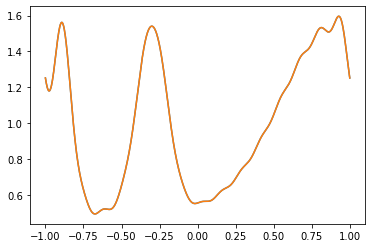

In [14]:
plt.plot(xs, ysf)
plt.plot(xs, ysd)

In [15]:
from time import *

In [16]:
def time_it(func):
    s = perf_counter()
    func()
    e = perf_counter()
    return (e - s)

In [17]:
def box_filter(func, iters = 32, bs = (0.25, 0.5)):
    times = np.array([time_it(func) for i in range(iters)])
    times = np.sort(times)
    ifrom, ito = int(iters * bs[0]), int(iters * bs[1])
    filtered = times[ifrom:ito]
    return np.mean(filtered), np.std(filtered)

In [18]:
def mmm_func(data, dtype) -> tuple:
    fp_data = np.ascontiguousarray(data, dtype = dtype)
    meanv = np.mean(fp_data)
    minv = np.min(fp_data)
    maxv = np.max(fp_data)
    return (meanv, minv, maxv)

In [19]:
import pandas as pd

In [20]:
ress = []

i = 1
while (2**(i + 1) < nz):
    i = i + 1
    npoints = int(2**i)
    rdict = {'npoints' : npoints}
    dataf, datad = zsf[:npoints], zsd[:npoints]
    fmmmf = lambda: mmm_func(dataf, np.float32)
    funcf = lambda: density_fourier(dataf)
    rdict['resmf'], rdict['devmf'] = box_filter(fmmmf)
    print('fm', npoints, rdict['resmf'], rdict['devmf'])
    rdict['resf'], rdict['devf'] = box_filter(funcf)
    print('f', npoints, rdict['resf'], rdict['devf'])
    fmmmd = lambda: mmm_func(datad, np.float64)
    funcd = lambda: density_fourier(datad)
    rdict['resmd'], rdict['devmd'] = box_filter(fmmmd)
    print('dm', npoints, rdict['resmd'], rdict['devmd'])
    rdict['resd'], rdict['devd'] = box_filter(funcd)
    print('d', npoints, rdict['resd'], rdict['devd'])
    ress.append(rdict)
    
ress = pd.DataFrame(ress)

fm 4 5.2527750001196694e-05 7.313016951074726e-06
f 4 6.530837500129394e-05 2.1372759465617512e-07
dm 4 3.880224999974757e-05 6.817578391167983e-08
d 4 7.502462499875406e-05 1.0502945943973002e-06
fm 8 5.194012499831757e-05 3.922048456756012e-06
f 8 0.00010282112500004104 2.5005444135152803e-06
dm 8 3.664412500015146e-05 2.878557801736536e-08
d 8 0.0001203753749994263 9.100771943857283e-06
fm 16 6.87830000005718e-05 2.277462515159811e-06
f 16 8.955100000029859e-05 3.447496119702692e-06
dm 16 4.3602625001248896e-05 1.5488619970417837e-06
d 16 8.191112500011144e-05 2.6253927057132513e-06
fm 32 5.0367250000071806e-05 1.7283899852285973e-06
f 32 7.82575000002339e-05 5.936764703511365e-07
dm 32 3.7574750001212465e-05 5.324178324219159e-08
d 32 6.434450000014635e-05 1.7394036256970782e-07
fm 64 5.82843749992179e-05 3.5422469181323488e-06
f 64 0.0002792327499996361 8.575717853662486e-06
dm 64 4.63130000003531e-05 2.144240775160688e-06
d 64 0.00019041787500029272 2.2006097693952602e-06
fm 128 

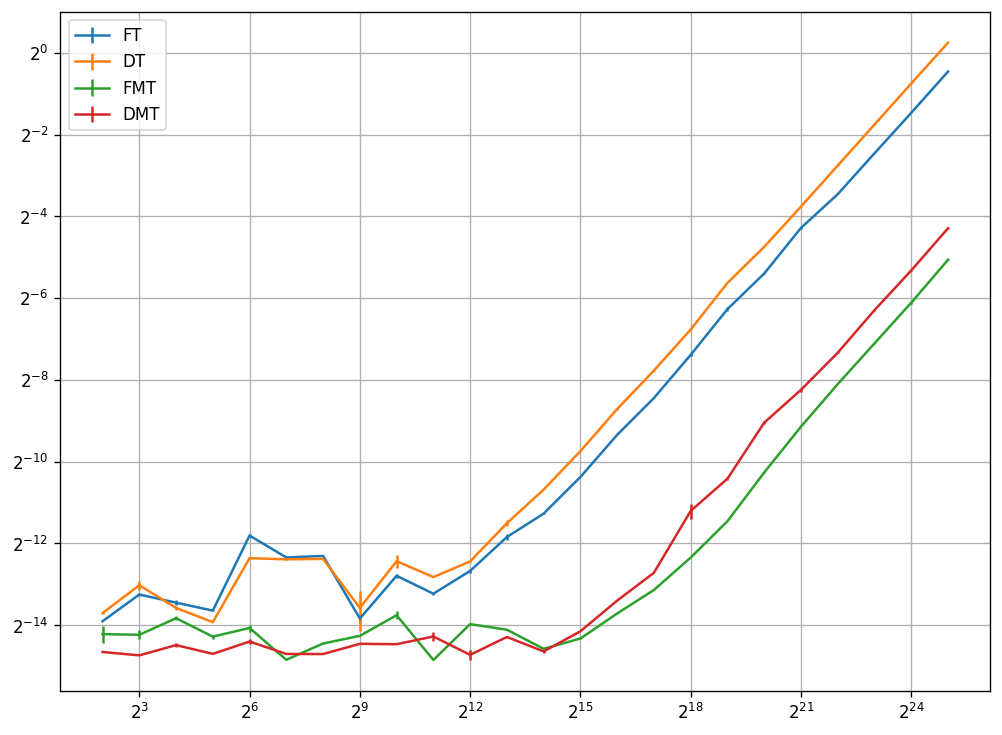

In [21]:
plt.figure(figsize = (10, 7.5), dpi = 120)
plt.xscale('log', basex = 2)
plt.yscale('log', basey = 2)
plt.errorbar(ress['npoints'], ress['resf'], yerr = ress['devf'], label = "FT")
plt.errorbar(ress['npoints'], ress['resd'], yerr = ress['devd'], label = "DT")
plt.errorbar(ress['npoints'], ress['resmf'], yerr = ress['devmf'], label = "FMT")
plt.errorbar(ress['npoints'], ress['resmd'], yerr = ress['devmd'], label = "DMT")
plt.legend()
plt.grid()

In [22]:
ress.to_csv('perf-avx-float-vs-avx-double.csv', index = False)

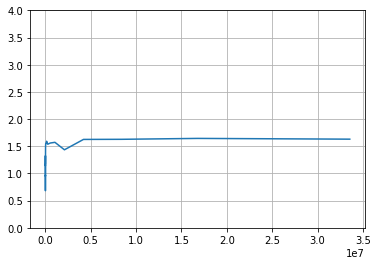

In [23]:
plt.ylim(0, 4)
plt.plot(ress['npoints'], ress['resd'] / ress['resf'])
plt.grid()